In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-08-10 02:18:55,847: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-08-10 02:18:55,884: INFO: common: yaml file: params.yaml loaded successfully]
[2024-08-10 02:18:55,894: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-08-10 02:18:55,897: INFO: common: created directory at: artifacts]
[2024-08-10 02:18:55,902: INFO: 3952428601: Config: {'artifacts_root': 'artifacts', 'data_ingestion': {'root_dir': 'artifacts/data_ingestion', 'source_URL': 'https://github.com/farshidhesami/Branching-tutorial/raw/master/Sandblasting-Condition.zip', 'local_data_file': 'artifacts/data_ingestion/data.zip', 'unzip_dir': 'artifacts/data_ingestion'}, 'data_validation': {'root_dir': 'artifacts/data_validation', 'unzip_data_dir': 'artifacts/data_ingestion/Sandblasting-Condition.csv', 'STATUS_FILE': 'artifacts/data_validation/status.txt'}, 'data_transformation': {'root_dir': 'artifacts/data_transformation', 'data_path': 'artifacts/data_ingestion/Sandblasting-Condition

,Angle of Sandblasting,Pressure of Sandblasting (bar),Temperture of Acid Etching,Time of Acid Etching (min),Time of Anodizing (min),Angle of Sandblasting^2,Angle of Sandblasting Pressure of Sandblasting (bar),Angle of Sandblasting Temperture of Acid Etching,Angle of Sandblasting Time of Acid Etching (min),Angle of Sandblasting Voltage of Anodizing (v),...,Temperture of Acid Etching Time of Acid Etching (min),Temperture of Acid Etching Voltage of Anodizing (v),Temperture of Acid Etching Time of Anodizing (min),Time of Acid Etching (min)^2,Time of Acid Etching (min) Voltage of Anodizing (v),Voltage of Anodizing (v) Time of Anodizing (min),Time of Anodizing (min)^2,(Sa) Average of Surface roughness (micrometer),Cell Viability (%),"Result (1=Passed, 0=Failed)"
0,0.450251,1.486148,-0.568421,1.560135,1.158516,0.344142,1.259372,-0.243462,1.661042,0.172043,...,0.580893,-0.141059,0.422600,1.713934,1.134834,0.320293,1.258956,NaN,NaN,NaN
1,1.781426,1.486148,0.812030,-1.059351,1.158516,1.872038,2.379795,1.980974,-0.505062,0.226123,...,-0.612883,0.016206,1.371225,-0.950965,-0.711798,0.169425,1.258956,NaN,NaN,NaN
2,0.450251,-1.208734,0.812030,-1.059351,1.158516,0.344142,-0.533306,1.027644,-0.814505,0.172043,...,-0.612883,0.173471,1.371225,-0.950965,-0.569749,0.320293,1.258956,NaN,NaN,NaN
3,1.781426,0.138707,0.812030,0.250392,1.158516,1.872038,1.259372,1.980974,1.042155,0.496528,...,0.580893,0.173471,1.371225,0.048372,0.282542,0.320293,1.258956,NaN,NaN,NaN
4,-0.880925,0.138707,-0.568421,0.250392,1.158516,-0.844221,-0.533306,-0.879016,-0.195618,-0.152442,...,-0.214958,-0.141059,0.422600,0.048372,0.282542,0.320293,1.258956,NaN,NaN,NaN



Data shape: (50, 25)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 25 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Angle of Sandblasting                                      28 non-null     float64
 1   Pressure of Sandblasting (bar)                             28 non-null     float64
 2   Temperture of Acid Etching                                 28 non-null     float64
 3   Time of Acid Etching (min)                                 28 non-null     float64
 4   Time of  Anodizing (min)                                   28 non-null     float64
 5   Angle of Sandblasting^2                                    28 non-null     float64
 6   Angle of Sandblasting Pressure of Sandblasting (bar)       28 non-null     float64
 7   Angle of Sandblasting Temperture of Acid Etching           28 non-

,Angle of Sandblasting,Pressure of Sandblasting (bar),Temperture of Acid Etching,Time of Acid Etching (min),Time of Anodizing (min),Angle of Sandblasting^2,Angle of Sandblasting Pressure of Sandblasting (bar),Angle of Sandblasting Temperture of Acid Etching,Angle of Sandblasting Time of Acid Etching (min),Angle of Sandblasting Voltage of Anodizing (v),...,Temperture of Acid Etching Time of Acid Etching (min),Temperture of Acid Etching Voltage of Anodizing (v),Temperture of Acid Etching Time of Anodizing (min),Time of Acid Etching (min)^2,Time of Acid Etching (min) Voltage of Anodizing (v),Voltage of Anodizing (v) Time of Anodizing (min),Time of Anodizing (min)^2,(Sa) Average of Surface roughness (micrometer),Cell Viability (%),"Result (1=Passed, 0=Failed)"
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,...,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.037754,0.080677,0.113104,-0.048152,0.175028,0.033816,0.087250,0.127231,-0.049219,-0.091522,...,0.008518,-0.088602,0.149923,-0.087922,-0.118165,-0.050582,0.191182,1.980351,28.503151,0.039916
std,1.009908,1.068217,0.939821,0.895374,1.030672,1.013276,1.082926,1.001693,0.847467,0.283672,...,0.913951,0.216854,0.977965,0.875186,0.534054,0.334779,1.039454,0.593280,38.540349,0.188788
min,-0.880925,-1.208734,-1.948872,-1.059351,-1.391886,-0.844221,-1.205560,-1.832345,-1.123948,-0.476927,...,-1.408734,-0.560432,-1.379787,-0.950965,-0.853847,-0.524566,-1.110642,1.207000,0.000000,0.000000
25%,-0.880925,-1.208734,-0.568421,-1.059351,-0.258374,-0.844221,-0.533306,-0.402351,-0.582423,-0.314685,...,-0.612883,-0.141059,-0.223097,-0.950965,-0.605261,-0.283178,-0.536194,1.457250,0.000000,0.000000
50%,0.000000,0.138707,0.812030,0.250392,0.000000,-0.095803,-0.024609,0.074314,-0.195618,-0.152442,...,-0.142843,-0.088388,-0.051713,0.048372,-0.001555,-0.066827,-0.298062,1.851000,0.000000,0.000000
75%,0.450251,1.486148,0.812030,0.250392,1.158516,0.344142,1.259372,1.027644,0.423269,0.172043,...,0.580893,0.016206,1.371225,0.048372,0.282542,0.320293,1.258956,2.411500,74.250000,0.000000
max,1.781426,1.486148,0.812030,1.560135,1.158516,1.872038,2.379795,1.980974,1.661042,0.496528,...,1.774669,0.173471,1.371225,1.713934,1.134834,0.320293,1.258956,3.426000,96.000000,1.000000



Missing values by column:
Angle of Sandblasting                                        22
Pressure of Sandblasting (bar)                               22
Temperture of Acid Etching                                   22
Time of Acid Etching (min)                                   22
Time of  Anodizing (min)                                     22
Angle of Sandblasting^2                                      22
Angle of Sandblasting Pressure of Sandblasting (bar)         22
Angle of Sandblasting Temperture of Acid Etching             22
Angle of Sandblasting Time of Acid Etching (min)             22
Angle of Sandblasting Voltage of Anodizing (v)               22
Angle of Sandblasting Time of  Anodizing (min)               22
Pressure of Sandblasting (bar)^2                             22
Pressure of Sandblasting (bar) Temperture of Acid Etching    22
Pressure of Sandblasting (bar) Time of  Anodizing (min)      22
Temperture of Acid Etching^2                                 22
Temperture of

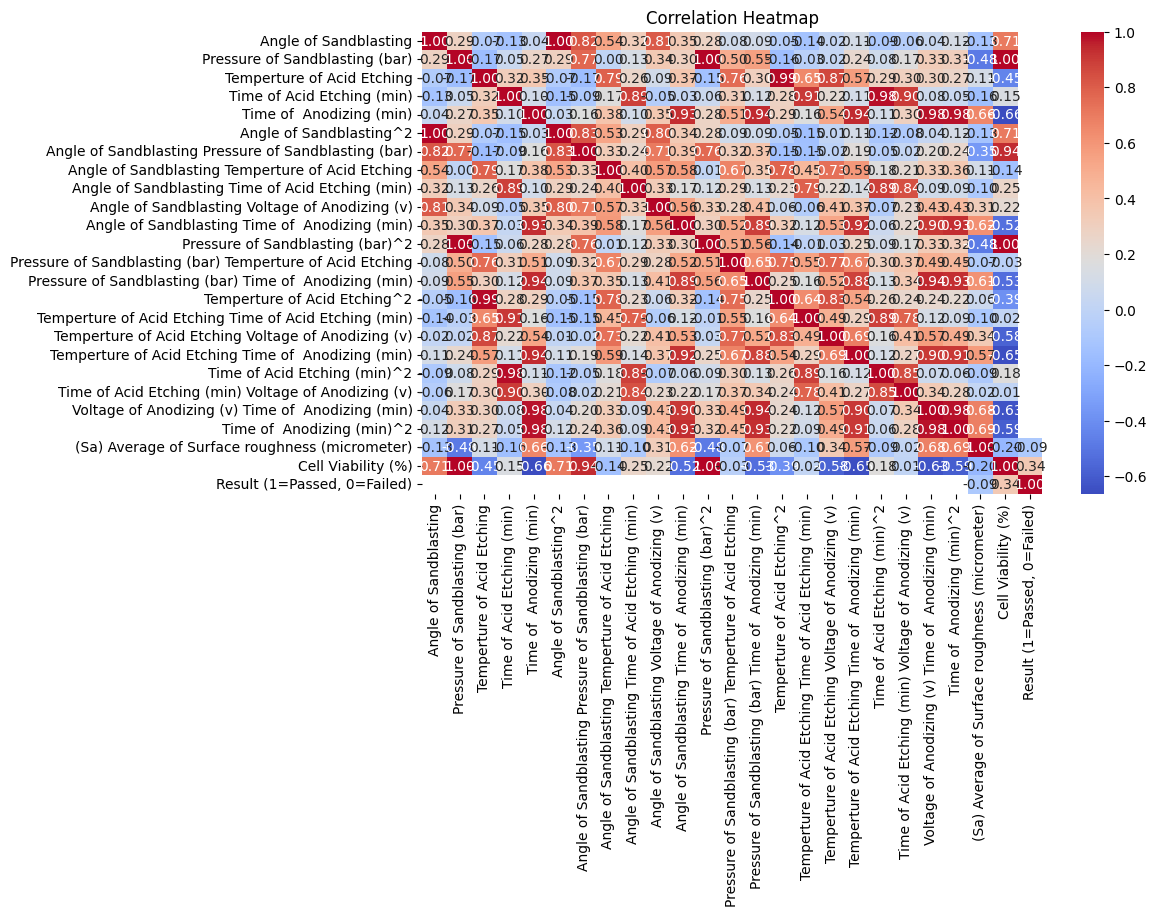

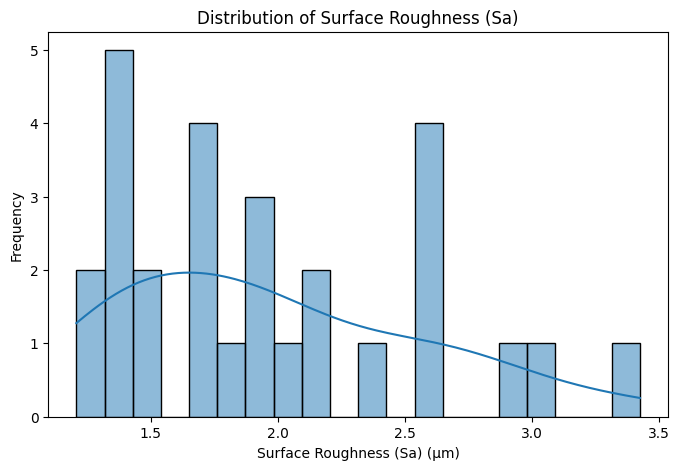

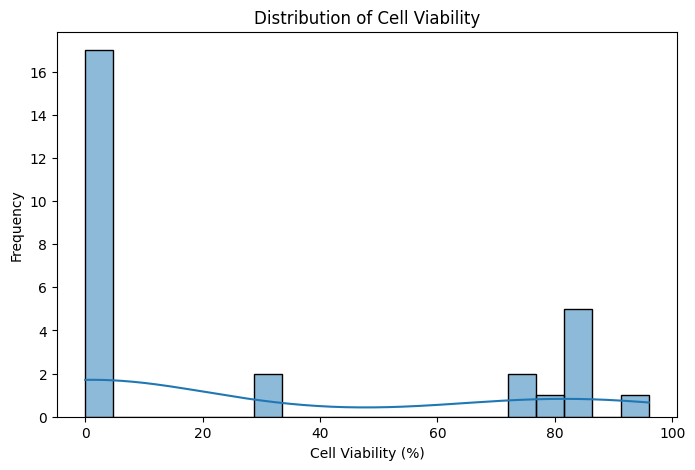

[2024-08-10 02:19:03,387: INFO: 3952428601: Evaluating the model.]


C:\Users\Farshid Hesami\AppData\Local\Temp\ipykernel_8696\3952428601.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[feature] = 0
C:\Users\Farshid Hesami\AppData\Local\Temp\ipykernel_8696\3952428601.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[feature] = 0
C:\Users\Farshid Hesami\AppData\Local\Temp\ipykernel_8696\3952428601.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

[2024-08-10 02:19:03,751: ERROR: 3952428601: Error during model evaluation]
Traceback (most recent call last):
  File "C:\Users\Farshid Hesami\AppData\Local\Temp\ipykernel_8696\3952428601.py", line 240, in evaluate_model
    X_poly_test = self.poly.transform(X_test_imputed)
  File "c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\preprocessing\_polynomial.py", line 432, in transform
    X = self._validate_data(
  File "c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\base.py", line 625, in _validate_data
    self._check_n_features(X, reset=reset)
  File "c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\base.py", line 414, in _check_n_features
    raise ValueError(
ValueError: X has 22 features, but PolynomialFeatures is expecting 24 featu

ValueError: X has 22 features, but PolynomialFeatures is expecting 24 features as input.

In [5]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories, save_json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from urllib.parse import urlparse
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import yaml
import logging
from sklearn.impute import SimpleImputer  # Added import for SimpleImputer
import json
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel


# Initialize logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define ModelEvaluationConfig dataclass
@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    all_params: dict
    metric_file_name: Path
    target_column: str

# Define ConfigurationManager class
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH, schema_filepath=SCHEMA_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        create_directories([self.config['artifacts_root']])
        logger.info(f"Config: {self.config}")
        logger.info(f"Params: {self.params}")
        logger.info(f"Schema: {self.schema}")

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        evaluation_config = self.config['model_evaluation']
        return ModelEvaluationConfig(
            root_dir=Path(evaluation_config['root_dir']),
            test_data_path=Path(evaluation_config['test_data_path']),
            model_path=Path(evaluation_config['model_path']),
            all_params=self.config,
            metric_file_name=Path(evaluation_config['metric_file_name']),
            target_column=evaluation_config['target_column']
        )

# Define ModelEvaluation class
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
        self.test_data = None
        self.model_sa = None
        self.model_cv = None
        self.poly = None
        self.expected_features = None
        self.expected_feature_names = None

    def load_data(self):
        try:
            self.test_data = pd.read_csv(self.config.test_data_path)
            logger.info("Test data loaded successfully.")
        except Exception as e:
            logger.exception("Error loading test data")
            raise e

    def load_model(self):
        try:
            model_sa_path = self.config.model_path / 'best_model_sa.joblib'
            model_cv_path = self.config.model_path / 'best_model_cv.joblib'
            poly_path = self.config.model_path / 'poly_features.joblib'
            features_info_path = self.config.model_path / 'features_info.json'

            # Check if model and feature files exist
            if not model_sa_path.exists():
                logger.error(f"Model file not found: {model_sa_path}")
                raise FileNotFoundError(f"No such file: '{model_sa_path}'")

            if not model_cv_path.exists():
                logger.error(f"Model file not found: {model_cv_path}")
                raise FileNotFoundError(f"No such file: '{model_cv_path}'")

            if not poly_path.exists():
                logger.error(f"Polynomial features file not found: {poly_path}")
                raise FileNotFoundError(f"No such file: '{poly_path}'")

            if not features_info_path.exists():
                logger.error(f"Features info file not found: {features_info_path}")
                raise FileNotFoundError(f"No such file: '{features_info_path}'")

            # Load models and polynomial features
            self.model_sa = joblib.load(model_sa_path)
            self.model_cv = joblib.load(model_cv_path)
            self.poly = joblib.load(poly_path)

            # Load expected features count and names
            with open(features_info_path, 'r') as f:
                features_info = json.load(f)
                self.expected_features = features_info['n_features']
                self.expected_feature_names = features_info['feature_names']


            logger.info("Models and polynomial features loaded successfully.")
        except Exception as e:
            logger.exception("Error loading models or polynomial features")
            raise e

    def apply_polynomial_features(self, X):
        try:
            # Impute missing values
            imputer = SimpleImputer(strategy='mean')
            X_imputed = imputer.fit_transform(X)

            # Apply polynomial transformation
            X_poly = self.poly.transform(X_imputed)

            # Ensure the transformed data has the correct number of features
            current_features = X_poly.shape[1]
            if current_features != self.expected_features:
                raise ValueError(f"Transformed data has {current_features} features, but {self.expected_features} were expected.")

            return X_poly
        except Exception as e:
            logger.exception("Error applying polynomial features")
            raise e


    def data_exploration(self):
        try:
            logger.info("Performing data exploration.")
            print("First few rows of the dataset:")
            display(self.test_data.head())

            print(f"\nData shape: {self.test_data.shape}")
            print("\nData info:")
            self.test_data.info()

            print("\nData types:")
            print(self.test_data.dtypes)

            print("\nSummary statistics:")
            display(self.test_data.describe(include='all'))

            print("\nMissing values by column:")
            print(self.test_data.isnull().sum())

            # Further EDA plots
            plt.figure(figsize=(10, 6))
            sns.heatmap(self.test_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.show()

            plt.figure(figsize=(8, 5))
            sns.histplot(self.test_data['(Sa) Average of Surface roughness (micrometer)'], kde=True, bins=20)
            plt.title("Distribution of Surface Roughness (Sa)")
            plt.xlabel("Surface Roughness (Sa) (µm)")
            plt.ylabel("Frequency")
            plt.show()

            plt.figure(figsize=(8, 5))
            sns.histplot(self.test_data['Cell Viability (%)'], kde=True, bins=20)
            plt.title("Distribution of Cell Viability")
            plt.xlabel("Cell Viability (%)")
            plt.ylabel("Frequency")
            plt.show()
        except Exception as e:
            logger.exception("Error during data exploration")
            raise e

    def eval_metrics(self, actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        mape = mean_absolute_percentage_error(actual, pred)
        medae = median_absolute_error(actual, pred)
        return rmse, mae, r2, mape, medae

    def save_results(self):
        try:
            test_data = pd.read_csv(self.config.test_data_path)
            model = joblib.load(self.config.model_path / 'model.joblib')

            test_x = test_data.drop([self.config.target_column], axis=1)
            test_y = test_data[[self.config.target_column]]

            predicted_qualities = model.predict(test_x)

            rmse, mae, r2, mape, medae = self.eval_metrics(test_y, predicted_qualities)

            # Saving metrics as local
            scores = {"rmse": rmse, "mae": mae, "r2": r2, "mape": mape, "medae": medae}
            save_json(path=Path(self.config.metric_file_name), data=scores)
            logger.info("Results saved successfully.")
        except Exception as e:
            logger.exception("Error during saving results")
            raise e

    def evaluate_model(self):
        try:
            logger.info("Evaluating the model.")

            # Drop target columns from the test set
            X_test = self.test_data.drop(columns=['(Sa) Average of Surface roughness (micrometer)', 'Cell Viability (%)', 'Result (1=Passed, 0=Failed)'])
            y_sa_test = self.test_data['(Sa) Average of Surface roughness (micrometer)']
            y_cv_test = self.test_data['Cell Viability (%)']

            # Impute missing values
            imputer = SimpleImputer(strategy='mean')
            X_test_imputed = imputer.fit_transform(X_test)

            # Load expected feature names from the loaded configuration
            expected_feature_names = self.expected_feature_names  # Correct attribute name

            # Ensure the test data has all the features used during training
            missing_features = set(expected_feature_names) - set(X_test.columns)

            # Add missing features with default values (e.g., zero)
            for feature in self.expected_feature_names:
                if feature not in X_test.columns:
                    X_test[feature] = 0

            # Ensure the order of columns is consistent with training
            X_test = X_test[self.expected_feature_names]

            # Transform with polynomial features (ensure the correct polynomial features are loaded)
            X_poly_test = self.poly.transform(X_test_imputed)


            # Proceed with Lasso feature selection and model evaluation
            lasso = LassoCV(max_iter=self.config.all_params['data_transformation']['lasso_max_iter'])
            model = SelectFromModel(lasso, prefit=True)
            X_selected_test = model.transform(X_poly_test)

            # Proceed with predictions and evaluation
            y_sa_pred = self.model_sa.predict(X_poly_test)
            valid_indices = (y_sa_pred > 1.5) & (y_sa_pred < 2.5)
            y_cv_pred = np.zeros_like(y_cv_test)

            if any(valid_indices):
                y_cv_pred[valid_indices] = self.model_cv.predict(X_poly_test[valid_indices])

            # Evaluation metrics for Surface Roughness (Sa)
            mae_sa = mean_absolute_error(y_sa_test, y_sa_pred)
            rmse_sa = np.sqrt(mean_squared_error(y_sa_test, y_sa_pred))
            r2_sa = r2_score(y_sa_test, y_sa_pred)
            mape_sa = mean_absolute_percentage_error(y_sa_test, y_sa_pred)
            medae_sa = median_absolute_error(y_sa_test, y_sa_pred)

            print(f"Surface Roughness (Sa) - Test MAE: {mae_sa:.4f}")
            print(f"Surface Roughness (Sa) - Test RMSE: {rmse_sa:.4f}")
            print(f"Surface Roughness (Sa) - Test R2: {r2_sa:.4f}")
            print(f"Surface Roughness (Sa) - Test MAPE: {mape_sa:.4f}")
            print(f"Surface Roughness (Sa) - Test MedAE: {medae_sa:.4f}")

            # Cross-validation scores
            cv_scores = cross_val_score(self.model_sa, X_selected_test, y_sa_test, cv=5, scoring='neg_mean_absolute_error')
            print(f"Cross-Validation MAE (Sa): {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

            # Residuals
            residuals = y_sa_test - y_sa_pred

            # Residual plot
            plt.figure(figsize=(10, 6))
            plt.scatter(y_sa_pred, residuals, alpha=0.5)
            plt.hlines(y=0, xmin=min(y_sa_pred), xmax=max(y_sa_pred), color='r', linestyles='dashed')
            plt.xlabel('Predicted Surface Roughness (Sa)')
            plt.ylabel('Residuals')
            plt.title('Residual Plot for Surface Roughness (Sa)')
            plt.show()

            # Distribution of Residuals
            plt.figure(figsize=(10, 6))
            sns.histplot(residuals, kde=True)
            plt.title('Distribution of Residuals for Surface Roughness (Sa)')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.show()

            # Evaluate Cell Viability (CV)
            if any(valid_indices):
                mae_cv = mean_absolute_error(y_cv_test[valid_indices], y_cv_pred[valid_indices])
                rmse_cv = np.sqrt(mean_squared_error(y_cv_test[valid_indices], y_cv_pred[valid_indices]))
                r2_cv = r2_score(y_cv_test[valid_indices], y_cv_pred[valid_indices])
                mape_cv = mean_absolute_percentage_error(y_cv_test[valid_indices], y_cv_pred[valid_indices])
                medae_cv = median_absolute_error(y_cv_test[valid_indices], y_cv_pred[valid_indices])

                print(f"Cell Viability (CV) - Test MAE: {mae_cv:.4f}")
                print(f"Cell Viability (CV) - Test RMSE: {rmse_cv:.4f}")
                print(f"Cell Viability (CV) - Test R2: {r2_cv:.4f}")
                print(f"Cell Viability (CV) - Test MAPE: {mape_cv:.4f}")
                print(f"Cell Viability (CV) - Test MedAE: {medae_cv:.4f}")

                valid_colors = np.where(y_cv_pred[valid_indices] > 90, 'green', 'red')

                plt.figure(figsize=(10, 6))
                plt.scatter(y_cv_test[valid_indices], y_cv_pred[valid_indices], alpha=0.5, c=valid_colors)
                plt.plot([min(y_cv_test[valid_indices]), max(y_cv_test[valid_indices])], [min(y_cv_test[valid_indices]), max(y_cv_test[valid_indices])], color='r')
                plt.xlabel('Actual Cell Viability')
                plt.ylabel('Predicted Cell Viability')
                plt.title('Actual vs Predicted Cell Viability (Valid Predictions Only)')
                plt.show()

                plt.figure(figsize=(10, 6))
                plt.scatter(y_sa_test, y_sa_pred, alpha=0.5)
                plt.plot([min(y_sa_test), max(y_sa_test)], [min(y_sa_test), max(y_sa_test)], color='r')
                plt.xlabel('Actual Surface Roughness (Sa)')
                plt.ylabel('Predicted Surface Roughness (Sa)')
                plt.title('Actual vs Predicted Surface Roughness (Sa)')
                plt.show()

            # Learning Curves
            train_sizes, train_scores, test_scores = learning_curve(self.model_sa, X_poly_test, y_sa_test, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
            train_scores_mean = -train_scores.mean(axis=1)
            test_scores_mean = -test_scores.mean(axis=1)

            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores_mean, label='Training Error')
            plt.plot(train_sizes, test_scores_mean, label='Validation Error')
            plt.title('Learning Curve')
            plt.xlabel('Training Set Size')
            plt.ylabel('Mean Absolute Error')
            plt.legend()
            plt.show()

        except Exception as e:
            logger.exception("Error during model evaluation")
            raise e

    def make_predictions(self):
        try:
            logger.info("Making predictions.")
            X_new = self.test_data.drop(columns=['(Sa) Average of Surface roughness (micrometer)', 'Cell Viability (%)', 'Result (1=Passed, 0=Failed)'])
            X_poly_new = self.poly.transform(X_new)
            y_sa_pred_new = self.model_sa.predict(X_poly_new)
            y_cv_pred_new = np.zeros_like(y_sa_pred_new)
            valid_indices_new = (y_sa_pred_new > 1.5) & (y_sa_pred_new < 2.5)
            if any(valid_indices_new):
                y_cv_pred_new[valid_indices_new] = self.model_cv.predict(X_poly_new[valid_indices_new])

            results = pd.DataFrame({
                'Predicted Surface Roughness (Sa)': y_sa_pred_new,
                'Predicted Cell Viability (%)': y_cv_pred_new,
                'Validity': np.where(y_cv_pred_new > 90, 'green', 'red')
            })
            print(results)

            plt.figure(figsize=(10, 6))
            plt.scatter(y_sa_pred_new, y_cv_pred_new, c=results['Validity'], alpha=0.5)
            plt.axhline(90, color='r', linestyle='dashed', linewidth=1)
            plt.xlabel('Predicted Surface Roughness (Sa)')
            plt.ylabel('Predicted Cell Viability (%)')
            plt.title('Predicted Surface Roughness vs Predicted Cell Viability')
            plt.colorbar(label='Validity')
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.hist(y_sa_pred_new, bins=20, alpha=0.7, label='Surface Roughness (Sa)')
            plt.axvline(1.5, color='r', linestyle='dashed', linewidth=1)
            plt.axvline(2.5, color='r', linestyle='dashed', linewidth=1)
            plt.title('Distribution of Predicted Surface Roughness (Sa)')
            plt.xlabel('Surface Roughness (Sa)')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.hist(y_cv_pred_new, bins=20, alpha=0.7, label='Cell Viability (%)', color='orange')
            plt.axvline(90, color='r', linestyle='dashed', linewidth=1)
            plt.title('Distribution of Predicted Cell Viability (%)')
            plt.xlabel('Cell Viability (%)')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

            validity_counts = results['Validity'].value_counts()
            plt.figure(figsize=(8, 5))
            plt.bar(validity_counts.index, validity_counts.values, color=['red', 'green'])
            plt.xlabel('Prediction Validity')
            plt.ylabel('Count')
            plt.title('Count of Valid vs Invalid Predictions')
            plt.show()

            residuals = y_sa_pred_new - y_sa_pred_new

            plt.figure(figsize=(10, 6))
            plt.scatter(y_sa_pred_new, residuals, alpha=0.5)
            plt.hlines(y=0, xmin=min(y_sa_pred_new), xmax=max(y_sa_pred_new), color='r', linestyles='dashed')
            plt.xlabel('Predicted Surface Roughness (Sa)')
            plt.ylabel('Residuals')
            plt.title('Residual Plot for Predictions')
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.histplot(residuals, kde=True, color='blue')
            plt.title('Distribution of Residuals for Predictions')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.show()

        except Exception as e:
            logger.exception("Error during predictions")
            raise e

    def make_predictions(self):
        try:
            logger.info("Making predictions.")
            X_new = self.test_data.drop(columns=['(Sa) Average of Surface roughness (micrometer)', 'Cell Viability (%)', 'Result (1=Passed, 0=Failed)'])
            X_poly_new = self.poly.transform(X_new)
            y_sa_pred_new = self.model_sa.predict(X_poly_new)
            y_cv_pred_new = np.zeros_like(y_sa_pred_new)
            valid_indices_new = (y_sa_pred_new > 1.5) & (y_sa_pred_new < 2.5)
            if any(valid_indices_new):
                y_cv_pred_new[valid_indices_new] = self.model_cv.predict(X_poly_new[valid_indices_new])

            results = pd.DataFrame({
                'Predicted Surface Roughness (Sa)': y_sa_pred_new,
                'Predicted Cell Viability (%)': y_cv_pred_new,
                'Validity': np.where(y_cv_pred_new > 90, 'green', 'red')
            })
            print(results)

            plt.figure(figsize=(10, 6))
            plt.scatter(y_sa_pred_new, y_cv_pred_new, c=results['Validity'], alpha=0.5)
            plt.axhline(90, color='r', linestyle='dashed', linewidth=1)
            plt.xlabel('Predicted Surface Roughness (Sa)')
            plt.ylabel('Predicted Cell Viability (%)')
            plt.title('Predicted Surface Roughness vs Predicted Cell Viability')
            plt.colorbar(label='Validity')
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.hist(y_sa_pred_new, bins=20, alpha=0.7, label='Surface Roughness (Sa)')
            plt.axvline(1.5, color='r', linestyle='dashed', linewidth=1)
            plt.axvline(2.5, color='r', linestyle='dashed', linewidth=1)
            plt.title('Distribution of Predicted Surface Roughness (Sa)')
            plt.xlabel('Surface Roughness (Sa)')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.hist(y_cv_pred_new, bins=20, alpha=0.7, label='Cell Viability (%)', color='orange')
            plt.axvline(90, color='r', linestyle='dashed', linewidth=1)
            plt.title('Distribution of Predicted Cell Viability (%)')
            plt.xlabel('Cell Viability (%)')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

            validity_counts = results['Validity'].value_counts()
            plt.figure(figsize=(8, 5))
            plt.bar(validity_counts.index, validity_counts.values, color=['red', 'green'])
            plt.xlabel('Prediction Validity')
            plt.ylabel('Count')
            plt.title('Count of Valid vs Invalid Predictions')
            plt.show()

            residuals = y_sa_pred_new - y_sa_pred_new

            plt.figure(figsize=(10, 6))
            plt.scatter(y_sa_pred_new, residuals, alpha=0.5)
            plt.hlines(y=0, xmin=min(y_sa_pred_new), xmax=max(y_sa_pred_new), color='r', linestyles='dashed')
            plt.xlabel('Predicted Surface Roughness (Sa)')
            plt.ylabel('Residuals')
            plt.title('Residual Plot for Predictions')
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.histplot(residuals, kde=True, color='blue')
            plt.title('Distribution of Residuals for Predictions')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.show()
        except Exception as e:
            logger.exception("Error during predictions")
            raise e

# Pipeline execution
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluator = ModelEvaluation(config=model_evaluation_config)
    model_evaluator.load_data()
    model_evaluator.load_model()
    model_evaluator.data_exploration()
    model_evaluator.evaluate_model()
    model_evaluator.make_predictions()
    model_evaluator.save_results()
except Exception as e:
    logger.exception(e)
    raise e